<h1 align="center">PEFT from Scratch</h1>
Questions
1. How to implement different PEFT approaches ?
2. How to update these large pre-trained models with low resources  ?
3. How to apply PEFT methods to large language models for optimization of the model performance efficiently ?


### Setup and Requirements



We will use the pretrained model t5-small or autoregressive models like gpt-neo-125M for running our experimentation faster.

In [11]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import time 
from tqdm.notebook import tqdm 
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed
from IPython.display import display, HTML

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch

from transformers import AutoModelForSequenceClassification, AutoModelForCausalLM
from transformers import  AutoTokenizer, TrainingArguments, Trainer
from datasets import load_dataset
import datasets
from peft import get_peft_model, LoraConfig, TaskType, PrefixTuningConfig, PromptEncoderConfig



In [6]:
# parameters 
random_seed = 42
torch.manual_seed(random_seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = "google-t5/t5-small"
causal_model = "EleutherAI/gpt-neo-125m"

dataset = "stanfordnlp/imdb"

epochs = 3
batch_size = 8
learning_rate = 1e-4

max_length = 512


cpu


In [13]:
dataset= load_dataset('imdb', split=['train[45%:55%]', 'test[45%:55%]', 'unsupervised[45%:55%]'])
dataset = datasets.DatasetDict({
    "train":dataset[0],
    "test":dataset[1],
    "unsupervised":dataset[2]

})

classes = ["negative", "positive"]

dataset = dataset.map(
    lambda x : {"text_label": [classes[label] for label in x["label"]]},
    batched=True,
    num_proc=1,
)
dataset["train"][0]

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

{'text': "Recap: Full moon. A creature, a huge werewolf, is on the hunt. Not for flesh, not for blood (not that it seem to mind to take a bite on the way though), but for a mate. He is on the hunt for a girl. Not any girl though. The Girl. The girl that is pure (and also a werewolf, although she doesn't know it yet). Three, well check that, two cops (after the first scene) and an old bag lady is all that can stop it, or even knows that the thing killing and eating a lot of folks around full moon is a werewolf. This particular powerful werewolf, Darkwolf, is closing in on the girl. If he gets her, mankind is doomed. Now the cops has to find the girl, convince her not only that there is someone, a werewolf nonetheless, that wants to rape her, and perhaps kill her, but that she is a werewolf herself. And then they got to stop him...<br /><br />Comments: This is one for the boys, the teenage boys. A lot of scenes with semi-nude girls more or less important for the plot. Mostly less. Well I

## Problems with Fine-tuning
Fine-tuning large language models like GPT are expensive, present several significant challenges for the average user such as computational expense, storage requirements and operational flexibility when managing multiple fine-tuned models.
1. High computational requirements
2. Expensive storage for checkpoints
3. Slow task switching with multiple fine-tuned models
4. catastrophic forgetting
5. Quality and Representation of Fine-tuning Data

In [1]:
import torch 
import numpy as np


In [2]:
_ = torch.manual_seed(0)
# define a rank 2 matrix W of size 10 x 10
d, k = (10, 10)
W_r = 2
W = torch.randn(d, W_r) @ torch.randn(W_r, k)
print(W)
print(np.linalg.matrix_rank(W))
print(W.size())

# apply the singular value decomposition on W
# W = U x S x V^T
U, S, V = torch.svd(W)
# rank r factorization we only keep first r singular value from D and corresponding columns of S and V^T
U_r = U[:, :W_r]
S_r = torch.diag(S[:W_r])
V_r = V[:, :W_r].t()
print(S_r)
# Computing A = U_r x S_r and B = V_r
A = U_r @ S_r
B = V_r
print(f"shape of the A is : {A.shape}")
print(f"shape of the B is : {B.shape}")

# let's generate the random bias and input 
bias = torch.randn(d)
x = torch.randn(d)

# computing straight line
# y = W^Tx + bias
y = W @ x + bias
# compute y' = (A * B) x + bias
y_prime = (A @ B) @ x + bias

print(f"original y using W : \n {y}")
print(f"computed using BA: \n {y_prime}")

# total params elements
print(f"total params of W : {W.nelement()}")
print(f"total params of A and B: {B.nelement() + A.nelement()}")

tensor([[-1.0797,  0.5545,  0.8058, -0.7140, -0.1518,  1.0773,  2.3690,  0.8486,
         -1.1825, -3.2632],
        [-0.3303,  0.2283,  0.4145, -0.1924, -0.0215,  0.3276,  0.7926,  0.2233,
         -0.3422, -0.9614],
        [-0.5256,  0.9864,  2.4447, -0.0290,  0.2305,  0.5000,  1.9831, -0.0311,
         -0.3369, -1.1376],
        [ 0.7900, -1.1336, -2.6746,  0.1988, -0.1982, -0.7634, -2.5763, -0.1696,
          0.6227,  1.9294],
        [ 0.1258,  0.1458,  0.5090,  0.1768,  0.1071, -0.1327, -0.0323, -0.2294,
          0.2079,  0.5128],
        [ 0.7697,  0.0050,  0.5725,  0.6870,  0.2783, -0.7818, -1.2253, -0.8533,
          0.9765,  2.5786],
        [ 1.4157, -0.7814, -1.2121,  0.9120,  0.1760, -1.4108, -3.1692, -1.0791,
          1.5325,  4.2447],
        [-0.0119,  0.6050,  1.7245,  0.2584,  0.2528, -0.0086,  0.7198, -0.3620,
          0.1865,  0.3410],
        [ 1.0485, -0.6394, -1.0715,  0.6485,  0.1046, -1.0427, -2.4174, -0.7615,
          1.1147,  3.1054],
        [ 0.9088,  

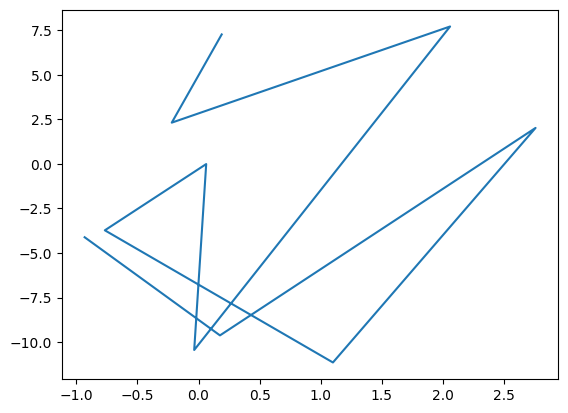

In [22]:
plt.plot(x, y)
plt.show()

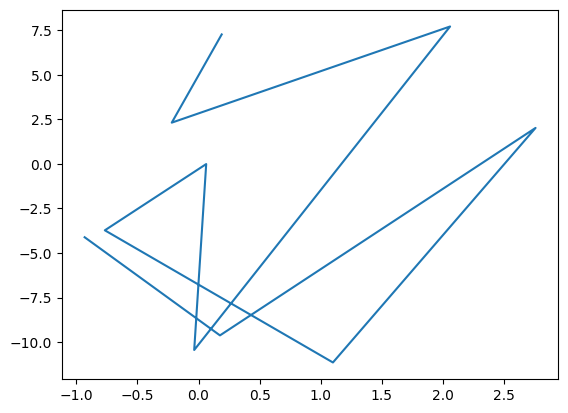

In [24]:
plt.plot(x, y_prime)

In [73]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

1. Training a NNs to classification of MNIST digits 
2. Fine-tuning the NNs on particular digit on which it does't perform well

In [74]:
# 1. data transformation pipeline 
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.1307,), (0.3081,))
])

# 2. loading the training dataset
mnist_train = datasets.MNIST(
    root='./dataset',
    train=True, 
    download=True,
    transform=transform
)

# creating the dataset loader for training
train_loader = torch.utils.data.DataLoader(
    mnist_train,
    batch_size=10,
    shuffle=True
)

# 3. loading the training dataset
mnist_test = datasets.MNIST(
    root='./dataset',
    train=False, 
    download=True,
    transform=transform
)

# creating the dataset loader for training
test_loader = torch.utils.data.DataLoader(
    mnist_test,
    batch_size=10,
    shuffle=True
)

device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [77]:
# NNs model for mnist digit classification
class NNClassifier(nn.Module):
    def __init__(self, hiddend_size1=1000, hiddend_size2=2000):
        super(NNClassifier, self).__init__()
        self.fc1 = nn.Linear(28*28, hiddend_size1)
        self.fc2 = nn.Linear(hiddend_size1, hiddend_size2)
        self.fc3 = nn.Linear(hiddend_size2, 10)
        self.relu = nn.ReLU()

    def forward(self, img):
        # Returns a new tensor with the same data as the self tensor but of a different shape .
        x = img.view(-1, 28*28)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = NNClassifier().to(device)

In [78]:
print(list(model.parameters()))

[Parameter containing:
tensor([[-0.0217,  0.0324,  0.0245,  ...,  0.0251, -0.0153,  0.0165],
        [-0.0317, -0.0023,  0.0119,  ..., -0.0138, -0.0319, -0.0170],
        [-0.0331,  0.0294, -0.0160,  ..., -0.0044,  0.0223, -0.0177],
        ...,
        [-0.0239, -0.0275, -0.0241,  ..., -0.0318, -0.0332,  0.0283],
        [-0.0185, -0.0276, -0.0083,  ..., -0.0080,  0.0042,  0.0142],
        [-0.0156, -0.0187, -0.0276,  ..., -0.0276, -0.0033, -0.0178]],
       requires_grad=True), Parameter containing:
tensor([-1.0320e-02, -6.5207e-03, -3.0425e-02,  3.1773e-02,  2.3648e-02,
         2.5797e-02, -5.3310e-03,  2.5184e-02,  2.8565e-02, -3.3112e-02,
        -1.9557e-02,  7.6884e-03,  2.5767e-02,  1.1022e-02,  1.7873e-02,
         3.6960e-03,  1.1287e-02, -5.3714e-03,  2.5341e-02,  6.2376e-03,
        -7.9755e-04, -1.4545e-02, -2.8868e-02,  3.0665e-02, -1.6053e-02,
         2.4567e-02, -3.2694e-02,  1.0266e-02, -1.8655e-02,  3.0986e-02,
        -1.3568e-02,  3.4876e-02, -2.9578e-02,  2.7216e

In [79]:
def training(train_loader, model, epochs, iter_limit=None):
    # loss function and optimizer
    loss_fun = nn.CrossEntropyLoss()
    optimizer= torch.optim.Adam(model.parameters(), lr=0.001)

    iter_total=0
    for epoch in range(epochs):
        model.train()
        
        loss_sum = 0
        iter_num = 0
        
        data_iter = tqdm(train_loader, desc=f'Epoch {epoch + 1}')
        if iter_limit is not None:
            data_iter.total = iter_limit
        for data in data_iter:
            iter_num += 1
            iter_total +=1

            x, y = data
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()

            output = model(x.view(-1, 28*28))
            loss  = loss_fun(output, y)

            
            loss_sum += loss.item()

            avg_loss = loss_sum / iter_num
            
            data_iter.set_postfix(loss=avg_loss)
            loss.backward()
            optimizer.step()

            if iter_limit is not None and iter_total >= iter_limit:
                return avg_loss
    return avg_loss

In [80]:
training(train_loader, model, epochs=1)

Epoch 1: 100%|██████████| 6000/6000 [01:43<00:00, 58.11it/s, loss=0.24] 


0.24042963718108756

In [81]:
# make a copy of the original model's weight, we use it to prive that LoRA fine-tuning does't alter the original weights
org_weights = {}
for name, param in model.named_parameters():
    org_weights[name] = param.clone().detach()

In [ ]:
# the performance of  NNClassifier model
# It poorly performed on digit 2
# so we will fine-tune the model for digit 2

def test():
    correct = 0
    total = 0
    wrong_counts = [0 for i in range(10)]

    with torch.no_grad():
        for data in tqdm(test_loader, desc='Testing'):
            x, y = data 
            x  = x.to(device)
            y = y.to(device)

            output = model(x.view(-1, 784))
            for idx, i in enumerate(output):
                if torch.argmax(i) == y[idx]:
                   correct +=1
                else:
                    wrong_counts[y[idx]] +=1
                total += 1
    print(f"Accuracy:{round(correct/total, 3)}")
    for i in range(len(wrong_counts)):
        print(f"Wrong count for digit {i}: {wrong_counts[i]}")

test()

Testing: 100%|██████████| 1000/1000 [00:00<00:00, 1041.01it/s]

Accuracy:0.959
Wrong count for digit 0: 10
Wrong count for digit 1: 11
Wrong count for digit 2: 103
Wrong count for digit 3: 37
Wrong count for digit 4: 57
Wrong count for digit 5: 38
Wrong count for digit 6: 19
Wrong count for digit 7: 70
Wrong count for digit 8: 37
Wrong count for digit 9: 33


In [85]:
# How many parameters are in the our model(NNClassifier) ?
# 1. print the size of weight matrix of the NNs
# 2. save the count of total number of parameters
total_params_org = 0
for index , layer in enumerate([model.fc1, model.fc2, model.fc3]):
    total_params_org += layer.weight.nelement() + layer.bias.nelement()

    print(f'Layer {index + 1} - W : {layer.weight.shape} + B: {layer.bias.shape}')

print(f'Total number of parameters: {total_params_org}')

Layer 1 - W : torch.Size([1000, 784]) + B: torch.Size([1000])
Layer 2 - W : torch.Size([2000, 1000]) + B: torch.Size([2000])
Layer 3 - W : torch.Size([10, 2000]) + B: torch.Size([10])
Total number of parameters: 2807010


In [ ]:
class LoRaParameterization(nn.Module):
   def __init__(self, features_in, features_out, rank=1, alpha=1, device='cpu'):
      super().__init__()

      # random gaussian initialization for a and zero for B
      self.A = nn.Parameter(torch.zeros(rank, features_out)).to(device)
      nn.init.normal_(self.A, mean=0, std=1)
      self.B = nn.Parameter(torch.zeros(features_in, rank)).to(device)

      # scale ∆Wx by α/r , where α is a constant in r.
      # When optimizing with adam, tuning α is roughly the same as tuning the learning rate if we scale the initialization appropriately.
      #   as a result, we simply set α to the first r we try and do not tune it.
      #   This scaling helps to reduce the need to retune hyperparameters when we vary r.
      self.scale = alpha / rank
      self.enabled = True
   def forward(self, org_weights):
      if self.enabled:
         return org_weights + torch.matmul(self.B, self.A).view(org_weights.shape)
      else:
         return org_weights

In [93]:
# addition of the parameters to our NNs
import torch.nn.utils.parametrize as parametrize

def LinearLayerParameterization(layer, device, rank=1, lora_alpha=1):
    # we only add parameterization to the weight matrix and ignore the bias
    # We limit our study to only adapting the attention weights for downstream tasks and freeze the MLP modules (so they are not trained in downstream tasks) both for simplicity and parameter-efficiency.
    # We leave the emphirical investigation of [...] and biases to a future work

    features_in, features_out = layer.weight.shape

    return LoRAParameterization(
        features_in,
        features_out,
        rank=rank,
        alpha=lora_alpha,
        device=device
    )

parametrize.register_parametrization(
    model.fc1, 
    "weight",
    LinearLayerParameterization(model.fc1, device)
)

parametrize.register_parametrization(
    model.fc2, 
    "weight",
    LinearLayerParameterization(model.fc2, device)
)

parametrize.register_parametrization(
    model.fc3, 
    "weight",
    LinearLayerParameterization(model.fc3, device)
)

def EnableDesableLoRA(enable=True):
    for layer in [model.fc1, model.fc2, model.fc3]:
        layer.parameterization["weight"][0].enabled = enabled

In [104]:
total_param_lora = 0
total_param_non_lora = 0
for index, layer in enumerate([model.fc1, model.fc2, model.fc3]):
    total_param_lora += layer.parametrizations["weight"][0].A.nelement() + layer.parametrizations["weight"][0].B.nelement()
    total_param_non_lora += layer.weight.nelement() + layer.weight.nelement()
    
    print(
       f'Layer {index+1}: W: {layer.weight.shape} + Bias: {layer.bias.shape} + Lora_A: {layer.parametrizations["weight"][0].A.shape} + Lora_B: {layer.parametrizations["weight"][0].B.shape}'
    )


# The non-LoRA param count must match the original network

print(f'Total number of param (original): {total_param_non_lora:,}')
print(f'Total number of param (original + LoRA): {total_param_lora + total_param_non_lora:,}')
print(f'Param introduced by LoRA: {total_param_lora:,}')
param_incremment = (total_param_lora / total_param_non_lora) * 100
print(f'Param incremment: {param_incremment:.3f}%')

Layer 1: W: torch.Size([1000, 784]) + Bias: torch.Size([1000]) + Lora_A: torch.Size([1, 784]) + Lora_B: torch.Size([1000, 1])
Layer 2: W: torch.Size([2000, 1000]) + Bias: torch.Size([2000]) + Lora_A: torch.Size([1, 1000]) + Lora_B: torch.Size([2000, 1])
Layer 3: W: torch.Size([10, 2000]) + Bias: torch.Size([10]) + Lora_A: torch.Size([1, 2000]) + Lora_B: torch.Size([10, 1])
Total number of param (original): 5,608,000
Total number of param (original + LoRA): 5,614,794
Param introduced by LoRA: 6,794
Param incremment: 0.121%


In [ ]:
# 1. Freeze all params of the original model
for name, param in model.named_parameters():
    if 'lora' not in name:
        print(f"Freezing Original params of models :  {name}")
        param.requires_grad=False

        
        
# 2. Finetuning the models params that introduced by LoRA on training digit 2
# let's load the mnist data set and keeping only the digit 2
train = datasets.MNIST(
    './dataset',
    train=True,
    download=True,
    transform=transform,
    )
exclud_idx = train.targets = 2
train.data = train.data[exclud_idx]
train.targets = train.targets[exclud_idx]

# creating the dataloader for the training
train_loader = torch.utils.data.DataLoader(
    train,
    batch_size=10,
    suffle=True)

# Train the network with LoRA only on the digit 2 and only for 100 batches (hoping that it would improve the performance on the digit 9)
train(train_loader, model, epochs=1, total_iterations_limit=100)

In [ ]:
# Verify that the fine-tuning didn't alter the original weights, but only the ones introduced by LoRA.
# Check that the frozen parameters are still unchanged by the finetuning
assert torch.all(net.linear1.parametrizations.weight.original == original_weights['linear1.weight'])
assert torch.all(net.linear2.parametrizations.weight.original == original_weights['linear2.weight'])
assert torch.all(net.linear3.parametrizations.weight.original == original_weights['linear3.weight'])

enable_disable_lora(enabled=True)
# The new linear1.weight is obtained by the "forward" function of our LoRA parametrization
# The original weights have been moved to net.linear1.parametrizations.weight.original
# More info here: https://pytorch.org/tutorials/intermediate/parametrizations.html#inspecting-a-parametrized-module
assert torch.equal(net.linear1.weight, net.linear1.parametrizations.weight.original + (net.linear1.parametrizations.weight[0].lora_B @ net.linear1.parametrizations.weight[0].lora_A) * net.linear1.parametrizations.weight[0].scale)

enable_disable_lora(enabled=False)
# If we disable LoRA, the linear1.weight is the original one
assert torch.equal(net.linear1.weight, original_weights['linear1.weight'])

In [ ]:
#Test the network with LoRA enabled (the digit 9 should be classified better)
# Test with LoRA enabled
enable_disable_lora(enabled=True)
test()
# Test the network with LoRA disabled (the accuracy and errors counts must be the same as the original network)
# Test with LoRA disabled
enable_disable_lora(enabled=False)
test()


## Reference
1. https://huggingface.co/EleutherAI/gpt-neo-125m
2. https://huggingface.co/google-t5/t5-small
3. https://huggingface.co/datasets/stanfordnlp/imdb

## Tutorials
1. Problem : https://colab.research.google.com/drive/1TyF-FmHN1Yd72qdaX-Z_a6kpcvWmH1FP?usp=sharing#scrollTo=_8C1P8OnezTP
2. Solutions : https://colab.research.google.com/drive/1t0FqAqS2m3eGHsSKlQnlidgrW4IcHjCw?usp=sharing#scrollTo=X7Eb4LrVzUM0
3. Summer School : https://colab.research.google.com/drive/1OkqcpLVbze_obiomPakArA5kabWbn3lO#scrollTo=kKGxLfu0wS-U

- HandsOn Tutorial Notebook by Prof. Ashutosh Modi: https://tinyurl.com/PEFT-HandsOn-Sol
- Huggingface PEFT Library: https://github.com/huggingface/peft/tree/main
- LoRA Paper: https://arxiv.org/pdf/2106.09685
- LoRA Explanation by Umar Jamil - https://www.youtube.com/watch?v=PXWYUTMt-AU
- QLoRA Paper: https://arxiv.org/pdf/2305.14314
- OLoRA Paper Explained: https://www.youtube.com/watch?v=6l8GZDPbFn8
- PEFT Hugging Face : https://huggingface.co/blog/samuellimabraz/peft-methods